# Getting Started with Projections

Here, we are showing some basic functionalities for analysing MD trajectories using `Projection` classes. First, let's import HTMD:

In [1]:
from htmd.ui import *
config(viewer='webgl')
#for inline plotting in Jupyter notebooks
%pylab inline


Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. 
https://dx.doi.org/10.1021/acs.jctc.6b00049
Documentation: http://software.acellera.com/
To update: conda update htmd -c acellera -c psi4

You are on the latest HTMD version (unpackaged : /home/joao/maindisk/software/repos/Acellera/htmd/htmd).

Populating the interactive namespace from numpy and matplotlib


## Projecting simulations

Get the data for this tutorial [here](http://pub.htmd.org/tutorials/projections/data.tar.gz). Alternatively, you can download the data using `wget`:

In [2]:
import os
assert os.system('wget -rcN -np -nH -q --cut-dirs=2 -R index.html* http://pub.htmd.org/tutorials/projections/data/') == 0

We will be doing two types of data projections:
* Projecting single Molecule objects
* Projecting lists of simulations

## Projecting single Molecule objects

One can load a previously simulated single MD trajectory (in this case, NTL9 protein) into a `Molecule` object and visualize it using:

In [3]:
mol = Molecule('data/ntl9_structure.pdb')
mol.read('data/ntl9_trajectory.xtc')
mol.filter('protein')
mol.view()

2018-03-15 23:57:31,506 - htmdmol.molecule - INFO - Removed 17 atoms. 631 atoms remaining in the molecule.


A Jupyter Widget

### Getting the RMSD along time

HTMD has many projection classes. One of those classes is `MetricRmsd`.

Using the `MetricRmsd` class, one may calculate the RMSD of a `Molecule` object against a reference structure (`refmol`, e.g. the crystal structure) for a given atom selection (`trajrmsdstr`):

In [4]:
crystal = Molecule('data/ntl9_crystal.pdb')
metr = MetricRmsd(refmol=crystal, trajrmsdstr='protein and name CA')
proj = metr.project(mol)
print(proj)

[ 16.36052132  15.79398251  14.12205887  14.77201653  13.90877914
  12.92834282  11.54159355  10.69192505  10.77845764  12.86611652]


The values are in Angstroms. They are quite high values, because the sample trajectory is of the unfolded protein (see the visualization above).

### Plot the RMSD along time

The previously obtained RMSD values can be easily plotted using matplotlib:

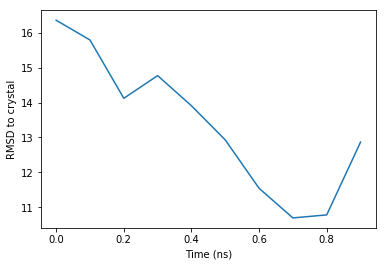

In [5]:
time_range = mol.fstep*np.arange(len(proj))
plt.plot(time_range, proj)
_ = plt.xlabel('Time (ns)')
_ = plt.ylabel('RMSD to crystal')

## Projecting a list of MD simulations

With the arrival of Markov state models, the paradigm of running one single long simulation has shifted to running hundreds or thousands of shorter simulations.

With the analysis of a large amount of MD trajectories in mind, in HTMD, the `simlist` function can be used to bundle all the trajectories together:

In [6]:
sims = simlist(glob('data/1/filtered/*/'), 'data/1/filtered/filtered.pdb')

Creating simlist: 100%|██████████| 314/314 [00:00<00:00, 2580.37it/s]


### Use Metric class to project a list of simulations

Using the `Metric` class, one can calculate all the projections of an entire simlist at once. In this case, the `MetricDistance` projection class is used, which calculates the matrix of distances between two selections (`sel1` and `sel2`):

In [7]:
metr = Metric(sims)
metr.set(MetricDistance(sel1='protein and name CA', sel2='resname MOL and noh', metric='distances'))
data = metr.project()
data.fstep = 0.1

Projecting trajectories: 100%|██████████| 313/313 [00:56<00:00,  5.57it/s]
2018-03-15 23:58:31,995 - htmd.projections.metric - INFO - Frame step 9.999999974752427e-07ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


Here, the projection is the matrix of distances between each carbon alpha of the protein and each heavy atom of the MOL molecule (which in the case of these trajectories, it's a ligand binding to the protein)

The `Metric.project` method returns a `MetricData` object which contains the trajectory and projection information:

In [8]:
print(data)

MetricData object with 313 trajectories of 6260.0ns aggregate simulation time
Centers: None
K: None
N: None
description: <class 'pandas.core.frame.DataFrame'> at 0x7f424512be80
fstep: 0.1
parent: <class 'NoneType'> at 0x7f42aa8aba70
trajectories shape: (313,)


## Working with MetricData objects

The `MetricData` object contains the information on each trajectory, including the corresponding projection. For example, for simulation 14:

In [9]:
print(data.trajectories[14])

sim: simid = 14
projection: np.array(shape=(200, 2493))
reference: np.array(shape=(200, 2))
cluster: None



The projection data can be easily accessed as a whole in the `MetricData.dat` property, which is an array of size equal to the number of trajectories. We can check the projection data of simulation 14 with:

In [10]:
data.dat[14]  # equivalent to data.trajectories[14].projection

array([[ 25.02148819,  22.95205688,  22.94793129, ...,  32.08512497,
         35.54423523,  36.99856567],
       [ 26.67520523,  23.7568512 ,  23.29753304, ...,  32.78013992,
         36.31970978,  37.90874863],
       [ 25.62865257,  23.9732132 ,  23.40108299, ...,  34.10222626,
         37.37914276,  38.52599335],
       ..., 
       [ 42.73937607,  43.45667648,  40.32186127, ...,  42.97974014,
         40.95644379,  42.0711174 ],
       [ 37.95848846,  40.92785263,  39.53430176, ...,  38.68696976,
         37.77161789,  39.62480164],
       [ 42.03954697,  42.95910263,  42.93307495, ...,  42.20518112,
         41.23760986,  42.07869339]], dtype=float32)

In [11]:
data.dat.shape

(313,)

In [12]:
bundledprojs = np.vstack(data.dat) # np.concatenate can be used instead as well
print(bundledprojs.shape)

(62600, 2493)


### Operations and calculations

One can use numpy functions like `np.min`, `np.max`, `np.average` to do calculations over the projected data:
* get the global minimum over all data

In [13]:
global_minimum = np.min(bundledprojs)
print(global_minimum)

2.92014


* get the maximum distance on each frame:

In [14]:
max_eachframe = np.max(bundledprojs,axis=1)
print(max_eachframe.shape)
max_eachframe

(62600,)


array([ 54.39825058,  53.99809647,  55.22867203, ...,  40.54018021,
        39.33503342,  37.30210876], dtype=float32)

* or get the average of each pair across all frames:

In [15]:
avg_acrossframes = np.average(bundledprojs,axis=0)
print(avg_acrossframes.shape)
avg_acrossframes

(2493,)


array([ 34.95511627,  33.69743729,  33.09692001, ...,  32.52411652,
        33.0621109 ,  33.91365433], dtype=float32)

The `axis` property is important to make the operation over the desired dimension:

* `axis=1`, in this case, operates over all pairs, to give a result for each frame
* `axis=0`, in this case, operates over all frames, to give a result for each pair

But how can we know to what particular atoms of the system corresponds a given indexed pair?

### Playing with the projection mapping

The mapping (meaning of each index) of the projection can be obtained from the `MetricData.map` property:

* the mapping is a pandas `DataFrame` object

The `head` method of `DataFrame` can be used to print the top entries of the mapping:

In [16]:
data.map.head()

,atomIndexes,description,type
0,"[4, 4480]",distance between GLU 1 CA and MOL 278 C3,distance
1,"[19, 4480]",distance between ALA 2 CA and MOL 278 C3,distance
2,"[29, 4480]",distance between ASP 3 CA and MOL 278 C3,distance
3,"[41, 4480]",distance between CYX 4 CA and MOL 278 C3,distance
4,"[51, 4480]",distance between GLY 5 CA and MOL 278 C3,distance


One can assess particular elements of the mapping through:

* `iloc` - i(nteger)loc(ation):

In [17]:
data.map.iloc[20:22]

,atomIndexes,description,type
20,"[321, 4480]",distance between ARG 21 CA and MOL 278 C3,distance
21,"[345, 4480]",distance between GLU 22 CA and MOL 278 C3,distance


 * `loc` (using the DataFrame index):

In [18]:
data.map.loc[20]

atomIndexes                                  [321, 4480]
description    distance between ARG 21 CA and MOL 278 C3
type                                            distance
Name: 20, dtype: object

* or direct assess to the array elements:

In [19]:
data.map['description'][20]

'distance between ARG 21 CA and MOL 278 C3'

One can use the mapping to find out to what particular pair of elements the minimum distance found in the trajectories corresponds to.

The `np.where` functionality gives us the array coordinates where a given condition is matched (in this case, when the distance is equal to the minimum):

In [20]:
print(global_minimum)
frame, index = np.where(bundledprojs == global_minimum)
print(index)
print(bundledprojs[frame, index]) # confirm that indeed these coordinates correspond the inquired value

2.92014
[2196]
[ 2.9201436]


Then, using the index in the mapping shown before:

In [21]:
data.map.iloc[index]

,atomIndexes,description,type
2196,"[4113, 4497]",distance between GLY 258 CA and MOL 278 N3,distance


gives us the atom indexes and description of the pair.